# Kaggle team name: vijf5!

# Members:
1. Jesse Coenraad -> JesseCoenraad
2. Jordan van Sintanneland -> JordanvanSint
3. Casper Priem -> CasperPriem
4. Jassar Hasiba -> UrClades

## Imports

In [54]:
import os
import librosa as lr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Audio
import pandas as pd

In [55]:
label_genre = pd.read_csv('labels_new.csv')

label_genre.head()

,filename,genre
0,m00248.wav,metal
1,m00230.wav,country
2,m00637.wav,hiphop
3,m00627.wav,metal
4,m00138.wav,reggae


In [56]:
#make a list object of unique genres in labels dataframe
genres = list(label_genre['genre'].unique())
genres


['metal',
 'country',
 'hiphop',
 'reggae',
 'classical',
 'jazz',
 'rock',
 'pop',
 'blues',
 'disco']

# Feature engineering

In [72]:
import librosa
import numpy as np
import pandas as pd
import os
from scipy.stats import skew, kurtosis

# Function to extract spectral features from an audio file
def extract_spectral_features(audio_file, sr=22050):
    try:
        # Load the audio file
        y, sr = librosa.load(audio_file, sr=sr)
        
        # Spectral Features
        features = {}

        # MFCCs
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        features['mfcc_mean'] = np.mean(mfccs, axis=1)
        features['mfcc_var'] = np.var(mfccs, axis=1)

        # Feature Trajectories
        mfcc_delta = librosa.feature.delta(mfccs)
        features['mfcc_delta_mean'] = np.mean(mfcc_delta, axis=1)
        features['mfcc_delta_var'] = np.var(mfcc_delta, axis=1)
        
        # Spectral Centroid
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        features['spectral_centroid_mean'] = np.mean(spectral_centroid)
        features['spectral_centroid_var'] = np.var(spectral_centroid)
        
        # Spectral Roll-off
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)
        features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)
        features['spectral_rolloff_var'] = np.var(spectral_rolloff)
        
        # Spectral Flux
        spectral_flux = librosa.onset.onset_strength(y=y, sr=sr)
        features['spectral_flux_mean'] = np.mean(spectral_flux)
        features['spectral_flux_var'] = np.var(spectral_flux)
        
        # Spectral Contrast
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        features['spectral_contrast_mean'] = np.mean(spectral_contrast, axis=1)
        features['spectral_contrast_var'] = np.var(spectral_contrast, axis=1)

        envelope = np.abs(y)
        features['envelope_mean'] = np.mean(envelope)
        features['envelope_var'] = np.var(envelope)

        # Spectral Bandwidth
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        features['spectral_bandwidth_mean'] = np.mean(spectral_bandwidth)
        features['spectral_bandwidth_var'] = np.var(spectral_bandwidth)

        # Time-Domain Features
        features['rms_mean'] = np.mean(librosa.feature.rms(y=y))
        features['rms_var'] = np.var(librosa.feature.rms(y=y))
        features['energy'] = np.sum(y ** 2) / len(y)  # Signal energy
        features['amplitude_mean'] = np.mean(np.abs(y))
        features['amplitude_var'] = np.var(np.abs(y))

        # Temporal Evolution
        dynamic_range = np.max(y) - np.min(y)
        features['dynamic_range'] = dynamic_range

        # Rhythm Features
        tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
        features['tempo'] = tempo
        beat_strength = librosa.onset.onset_strength(y=y, sr=sr)
        features['beat_strength_mean'] = np.mean(beat_strength)
        features['beat_strength_var'] = np.var(beat_strength)

        # Rhythmic Regularity
        if len(beat_frames) > 1:
            # Inter-Beat Interval (IBI) Variability
            ibi = np.diff(beat_frames) / sr  # Convert frame difference to seconds
            features['ibi_var'] = np.var(ibi)
            features['ibi_mean'] = np.mean(ibi)

        # Harmonic Features
        # Key and Scale Estimation
        chroma = librosa.feature.chroma_cqt(y=y, sr=sr)
        features['chroma_mean'] = np.mean(chroma, axis=1)
        features['chroma_var'] = np.var(chroma, axis=1)
        
        # Tonnetz
        tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
        features['tonnetz_mean'] = np.mean(tonnetz, axis=1)
        features['tonnetz_var'] = np.var(tonnetz, axis=1)

        # Harmonic-to-Percussive Ratio
        harmonic, percussive = librosa.effects.hpss(y)
        hpr = np.mean(harmonic) / (np.mean(percussive) + 1e-6)
        features['hpr'] = hpr

        # Genre-Specific Features
        # Harmonic and Percussive Energy
        features['harmonic_energy'] = np.sum(harmonic ** 2)
        features['percussive_energy'] = np.sum(percussive ** 2)

        # Zero-Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(y)
        features['zcr_mean'] = np.mean(zcr)
        features['zcr_var'] = np.var(zcr)

        # Onset Autocorrelation (Rhythmic Regularity)
        onset_acf = librosa.autocorrelate(librosa.onset.onset_strength(y=y, sr=sr), max_size=len(y)//2)
        features['onset_acf_mean'] = np.mean(onset_acf)
        features['onset_acf_var'] = np.var(onset_acf)

        # Statistics (Skewness and Kurtosis)
        features['skewness'] = skew(y)
        features['kurtosis'] = kurtosis(y)


        
        return features
    except Exception as e:
        print(f"Error processing {audio_file}: {e}")
        return None




# Function to process all files in a folder
def process_audio_folder(folder_path, output_csv="audio_features.csv"):
    feature_list = []
    file_names = []

    # Loop through all files in the folder
    for file_name in os.listdir(folder_path):
        # Check if the file is a valid audio file
        if file_name.endswith(('.wav', '.mp3', '.flac', '.ogg')):
            file_path = os.path.join(folder_path, file_name)
            print(f"Processing file: {file_name}")
            
            # Extract features
            features = extract_spectral_features(file_path)
            
            if features:
                # Flatten features and add file name
                flat_features = {}
                for key, value in features.items():
                    if isinstance(value, np.ndarray):
                        for i, val in enumerate(value):
                            flat_features[f"{key}_{i}"] = val
                    elif isinstance(value, list):
                        for i, val in enumerate(value):
                            flat_features[f"{key}_{i}"] = val
                    else:
                        flat_features[key] = value
                
                flat_features['file_name'] = file_name
                feature_list.append(flat_features)

    # Convert to DataFrame
    df = pd.DataFrame(feature_list)

    # Save to CSV
    df.to_csv(output_csv, index=False)
    print(f"Features saved to {output_csv}")


# Example usage
if __name__ == "__main__":
    # Path to your folder containing audio files
    folder_path = "labeled"
    
    # Process folder and save features to CSV
    process_audio_folder(folder_path, output_csv="audio_features.csv")


Processing file: m00002.wav
Processing file: m00039.wav
Processing file: m00041.wav
Processing file: m00072.wav
Processing file: m00096.wav
Processing file: m00102.wav
Processing file: m00112.wav
Processing file: m00138.wav
Processing file: m00192.wav
Processing file: m00206.wav
Processing file: m00230.wav
Processing file: m00236.wav
Processing file: m00248.wav
Processing file: m00253.wav
Processing file: m00298.wav
Processing file: m00313.wav
Processing file: m00338.wav
Processing file: m00339.wav
Processing file: m00351.wav
Processing file: m00400.wav
Processing file: m00421.wav
Processing file: m00429.wav
Processing file: m00435.wav
Processing file: m00454.wav
Processing file: m00477.wav
Processing file: m00501.wav
Processing file: m00503.wav
Processing file: m00513.wav
Processing file: m00553.wav
Processing file: m00606.wav
Processing file: m00623.wav
Processing file: m00627.wav
Processing file: m00629.wav
Processing file: m00633.wav
Processing file: m00637.wav
Processing file: m00

In [73]:
audio_features = pd.read_csv('audio_features.csv')

In [74]:
audio_features 

,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,...,hpr,harmonic_energy,percussive_energy,zcr_mean,zcr_var,onset_acf_mean,onset_acf_var,skewness,kurtosis,file_name
0,-298.756130,112.076280,6.488818,28.389170,-6.770987,16.645588,-11.807552,12.744363,-8.340971,13.893223,...,0.304814,2037.152600,39.700270,0.051224,0.000629,672.615950,1.643258e+05,0.088488,2.617145,m00002.wav
1,-169.153350,110.460000,-8.576200,43.884247,0.274970,26.637417,-14.368152,13.034431,-11.149249,8.130109,...,0.902208,6367.025400,3609.188200,0.072150,0.002673,2154.544733,2.526802e+06,0.106281,3.148987,m00039.wav
2,-18.845390,71.325660,-3.766896,-1.408726,0.705463,-1.058955,-1.054825,-0.247421,0.625723,0.427043,...,-0.625688,13829.234000,7554.969000,0.152857,0.004726,1287.389972,8.480074e+05,-0.037692,1.653724,m00041.wav
3,-69.630650,83.072270,-16.599928,0.118371,7.420607,0.770008,1.337478,4.695799,-1.416824,3.319435,...,0.445259,6298.012700,5382.889600,0.120217,0.001512,1514.820439,1.071666e+06,0.040828,3.730454,m00072.wav
4,-91.983770,87.640100,-2.066795,34.278150,-18.124573,19.345660,-14.665754,17.112078,-15.336204,17.028183,...,0.864006,8329.778000,16146.339000,0.115834,0.002543,2690.703379,4.645377e+06,0.071066,3.297007,m00096.wav
5,-436.858220,154.080430,-19.861961,20.182660,3.173895,0.450946,-6.527718,-4.608916,-10.058647,-6.156632,...,14.431386,70.465164,0.965078,0.066340,0.000420,418.380043,6.053867e+04,-0.006405,3.625285,m00102.wav
6,-265.698500,80.639626,9.737633,36.647457,27.827784,12.086293,15.011354,15.113030,6.559153,6.282747,...,1.743224,1832.455900,472.249330,0.060844,0.002927,2924.474336,3.811035e+06,0.159632,3.384229,m00112.wav
7,-198.732120,102.408325,-9.996930,30.804916,-3.292768,20.279371,-5.631608,28.096033,-11.504986,18.203848,...,-0.296817,2009.226300,2038.496600,0.070276,0.001469,1870.665730,2.053375e+06,0.128676,3.360906,m00138.wav
8,-85.308340,118.443060,-31.477154,20.282328,-4.417633,6.912192,-10.952412,-1.622339,-7.361473,-3.018685,...,0.370191,6029.661600,737.760440,0.111576,0.000603,599.857685,1.207132e+05,-0.151903,0.242558,m00192.wav
9,-92.645690,77.411550,-32.758095,54.586475,-13.199569,33.660706,-12.074937,28.023540,-11.954623,18.832200,...,0.023900,2457.102300,2602.588900,0.157556,0.002893,1103.963378,4.865585e+05,-0.043936,2.870614,m00206.wav


In [38]:
from pathlib import Path
import os

In [39]:
os.listdir('labeled')

['m00002.wav',
 'm00039.wav',
 'm00041.wav',
 'm00072.wav',
 'm00096.wav',
 'm00102.wav',
 'm00112.wav',
 'm00138.wav',
 'm00192.wav',
 'm00206.wav',
 'm00230.wav',
 'm00236.wav',
 'm00248.wav',
 'm00253.wav',
 'm00298.wav',
 'm00313.wav',
 'm00338.wav',
 'm00339.wav',
 'm00351.wav',
 'm00400.wav',
 'm00421.wav',
 'm00429.wav',
 'm00435.wav',
 'm00454.wav',
 'm00477.wav',
 'm00501.wav',
 'm00503.wav',
 'm00513.wav',
 'm00553.wav',
 'm00606.wav',
 'm00623.wav',
 'm00627.wav',
 'm00629.wav',
 'm00633.wav',
 'm00637.wav',
 'm00658.wav',
 'm00671.wav',
 'm00676.wav',
 'm00677.wav',
 'm00678.wav',
 'm00716.wav',
 'm00762.wav',
 'm00772.wav',
 'm00773.wav',
 'm00801.wav',
 'm00821.wav',
 'm00850.wav',
 'm00867.wav',
 'm00895.wav',
 'm00996.wav']

In [40]:
# Define the base directory where the subdirectories "cat" and "dog" are located
base_dir = "labeled"  # Replace with your directory path

# Initialize lists for audio data and labels
audio_data = []
sample_freqs = []
labels = []

# Target length for 5 seconds at a sample rate of 22050 Hz (adjust if different)
target_length = 5 * 22050

# Process each audio file
for label in label_genre['filename']:
    sub_dir = os.path.join(base_dir)
    for file in os.listdir(sub_dir):
        if file.endswith(".wav"):
            file_path = os.path.join(sub_dir, file)
            data, sfreq = lr.load(file_path, sr=None)  # Keep original sample rate

            # Truncate or pad the audio
            if len(data) > target_length:
                # Truncate the data
                data = data[:target_length]
            elif len(data) < target_length:
                # Pad with zeros
                padding = target_length - len(data)
                data = np.pad(data, (0, padding), mode='constant')

            # Append the processed data and label
            audio_data.append(data)
            sample_freqs.append(sfreq)
            labels.append(label)

audio_data = np.stack(audio_data, axis=0)
sample_freqs = np.array(sample_freqs)
labels = np.array(labels)

In [41]:
print(audio_data[:5], labels[:5])

[[-0.01635742 -0.02282715 -0.01467896 ...  0.00747681  0.00817871
   0.00772095]
 [-0.0947876  -0.15338135 -0.1439209  ... -0.18804932 -0.09313965
  -0.0645752 ]
 [ 0.07803345 -0.03765869  0.12664795 ...  0.06295776  0.0484314
   0.02236938]
 [ 0.1060791   0.08496094  0.06210327 ...  0.27041626  0.321167
   0.26272583]
 [-0.03607178 -0.10568237 -0.20123291 ... -0.05239868 -0.0506897
  -0.05014038]] ['m00248.wav' 'm00248.wav' 'm00248.wav' 'm00248.wav' 'm00248.wav']


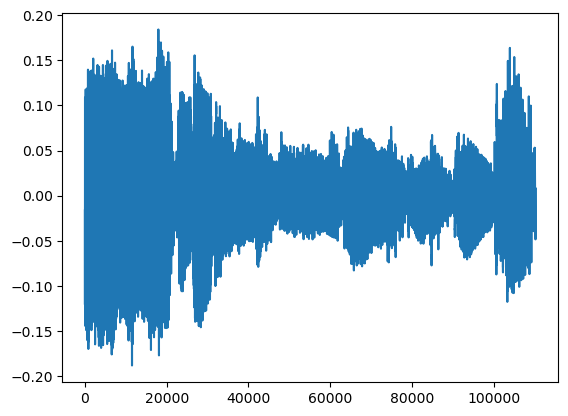

In [ ]:
plt.plot(audio_data[0])

In [43]:
# Pick a random audio clip
random_index = np.random.choice(len(audio_data), size=1, replace=False)
clip = audio_data[random_index][0]
sfreq = sample_freqs[random_index][0]
label = labels[random_index][0]

print(f"Label {label}")

# Play the clip
Audio(data=clip, rate=sfreq)

Label m00230.wav


In [44]:
from librosa.core import stft
from librosa.core import amplitude_to_db
from librosa.display import specshow

def calculate_spectrograms(audio_clips, n_fft=2048, hop_length=512, win_length=None):
    """
    Calculate the spectrogram for each audio clip in the audio_clips array.

    Parameters:
    - audio_clips: A list of audio clips (numpy arrays).
    - n_fft: The number of data points used in each block for the FFT (default 2048).
    - hop_length: The number of samples between successive frames (default 512).
    - win_length: The window size (default is `n_fft`).

    Returns:
    - spectrograms: A list of spectrograms corresponding to each audio clip.
    - spec_db: The spectrograms in decibels, for plotting
    """
    spectrograms = []
    spectrograms_db = []

    for clip in audio_clips:
        win_length = win_length or n_fft

        # Calculate the STFT. Use lr.stft() here.
        stft_matrix = stft(clip, n_fft=n_fft, hop_length=hop_length, win_length=win_length)



        # Calculate the magnitude of the STFT (spectrogram). Use np.abs() here.
        spectrogram = np.abs(stft_matrix)



        # Convert to decibels. Use amplitude_to_db() here.
        deci = amplitude_to_db(spectrogram, ref=np.max)


        # Append the spectrogram to the list
        spectrograms.append(spectrogram)



        # Append spectrogram in decibels to the list
        spectrograms_db.append(deci)



    return spectrograms, spectrograms_db

# Use function
spectrograms, spectrograms_db = calculate_spectrograms(audio_data, n_fft=2048, hop_length=512, win_length=None)



Label m00678.wav


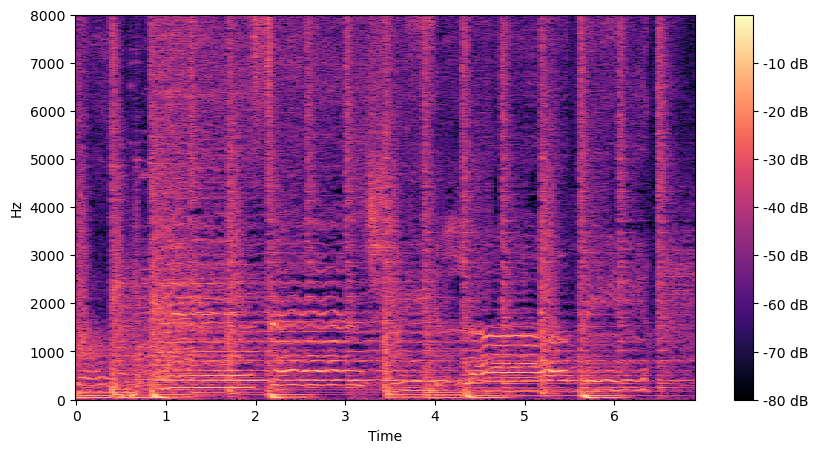

In [45]:
# Pick a random spectrogram
random_index = np.random.choice(len(spectrograms_db), size=1, replace=False)
spectrogram = spectrograms_db[random_index[0]]
clip = audio_data[random_index][0]
sfreq = sample_freqs[random_index][0]
label = labels[random_index][0]

print(f"Label {label}")

# Display the spectrogram
plt.figure(figsize=(10, 5))
img = specshow(spectrogram, x_axis='time', y_axis='hz', sr=16000, hop_length=512)
plt.colorbar(img, format='%+2.0f dB')
plt.show()

# Play the corresponding clip
Audio(data=clip, rate=sfreq)

In [46]:
def calculate_spectral_features(spectrograms):
    """
    Calculate the centroid and bandwidth for each spectrogram in a list.

    Parameters:
    - spectrograms: A list of spectrograms.

    Returns:
    - bandwidths: A list of bandwidths corresponding to each spectrogram
    - centroids: A list of centroids corresponding to each spectrogram
    """
    bandwidths = []
    centroids = []

    for spectrogram in spectrograms:

        # Calculate the bandwidth for the spectrogram (use lr.feature.spectral_bandwidth)
        bandwidths.append(lr.feature.spectral_bandwidth(S=spectrogram))



        # Calculate the spectral centroid for the spectrogram (use lr.feature.spectral_centroid)
        centroids.append(lr.feature.spectral_centroid(S=spectrogram))



    return bandwidths, centroids

# Use function
bandwidths, centroids = calculate_spectral_features(spectrograms)

Label m00678.wav


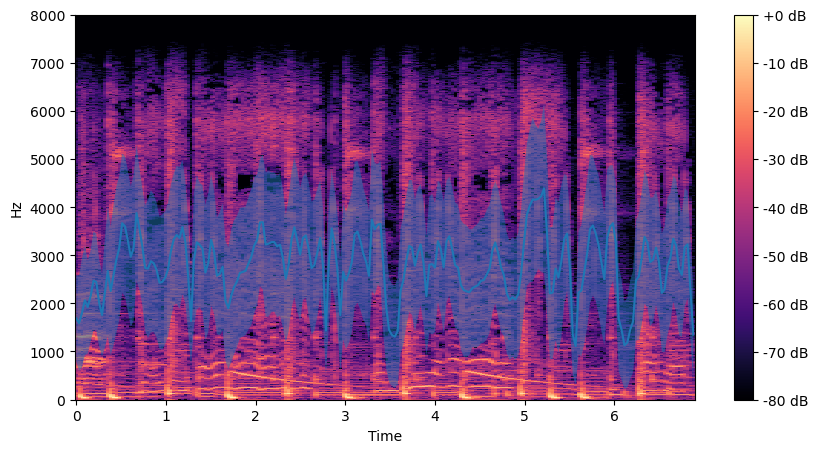

In [47]:
# Pick a random spectrogram
random_index = np.random.choice(len(spectrograms_db), size=1, replace=False)
spectrogram = spectrograms_db[random_index[0]]

# Get time index values
times_spec = lr.frames_to_time(range(spectrogram.shape[1]), sr=16000, hop_length=512)

bw = bandwidths[random_index[0]][0]
cent = centroids[random_index[0]][0]

clip = audio_data[random_index][0]
sfreq = sample_freqs[random_index][0]
label = labels[random_index][0]

print(f"Label {label}")

# Display the spectrogram
plt.figure(figsize=(10, 5))
img = specshow(spectrogram, x_axis='time', y_axis='hz', sr=16000, hop_length=512)
plt.plot(times_spec, cent)
plt.fill_between(times_spec, cent - bw / 2, cent + bw / 2, alpha=.5)
plt.colorbar(img, format='%+2.0f dB')
plt.show()

# Play the corresponding clip
Audio(data=clip, rate=sfreq)


In [48]:
mean_bw = np.mean(bandwidths)
mean_cent = np.mean(centroids)

In [49]:
features = pd.DataFrame(columns=['mean_bandwidth','mean_centroids'])

for i in range(len(bandwidths)):
    features.loc[i] = [np.mean(bandwidths[i]), np.mean(centroids[i])]

features.head()


,mean_bandwidth,mean_centroids
0,1966.890053,1439.764877
1,2012.207776,1769.254916
2,2961.971115,3050.586443
3,2548.466009,2240.970749
4,2635.935693,2793.609704


In [50]:
labels

array(['m00248.wav', 'm00248.wav', 'm00248.wav', ..., 'm00477.wav',
       'm00477.wav', 'm00477.wav'], dtype='<U10')

## Test, train split

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

In [52]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, shuffle=True)

# Unsupervised Learning